Этап: MVP (Фаза 1 + Фаза 2)

In [ ]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

plt.style.use('seaborn-v0_8') 
sns.set_palette("husl")

## ФАЗА 1: АНАЛИЗ ИНДУСТРИИ И КОМПЕТЕНЦИЙ

In [2]:
def get_vacancies(keyword, area=1, per_page=100, pages=2):
    """
    Функция для получения вакансий с hh.ru API.
    :param keyword: ключевое слово для поиска (например, "программист")
    :param area: регион (1 - Москва, 113 - Россия)
    :param per_page: количество вакансий на странице
    :param pages: количество страниц для парсинга
    :return: список вакансий
    """
    base_url = "https://api.hh.ru/vacancies"
    all_vacancies = []
    
    for page in range(pages):
        params = {
            'text': keyword,
            'area': area,
            'per_page': per_page,
            'page': page
        }
        
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            vacancies = data.get('items', [])
            all_vacancies.extend(vacancies)
            
            print(f"✅ Получено {len(vacancies)} вакансий со страницы {page + 1}")
            
            time.sleep(0.5)
            
        except Exception as e:
            print(f"❌ Ошибка при получении страницы {page}: {e}")
            break
    
    return all_vacancies

# --- Запуск парсинга ---
print("🚀 Начинаем сбор данных с hh.ru...")
vacancies = get_vacancies("программист", area=113, per_page=100, pages=2) 

print(f"\n📊 Всего собрано вакансий: {len(vacancies)}")

# Проверка: если вакансий нет — не продолжаем
if len(vacancies) == 0:
    print("⚠️ Нет данных. Проверь подключение и параметры запроса.")
else:
    df_vacancies = pd.DataFrame(vacancies)

    def safe_get(obj, *keys):
        for key in keys:
            if isinstance(obj, dict) and key in obj:
                obj = obj[key]
            else:
                return None
        return obj

    df_vacancies['employer_name'] = df_vacancies['employer'].apply(lambda x: safe_get(x, 'name'))
    df_vacancies['salary_from'] = df_vacancies['salary'].apply(lambda x: safe_get(x, 'from'))
    df_vacancies['area_name'] = df_vacancies['area'].apply(lambda x: safe_get(x, 'name'))

    print("\n📌 Первые 5 вакансий:")
    print(df_vacancies[['name', 'employer_name', 'salary_from', 'area_name']].head())

🚀 Начинаем сбор данных с hh.ru...
✅ Получено 100 вакансий со страницы 1
✅ Получено 100 вакансий со страницы 2

📊 Всего собрано вакансий: 200

📌 Первые 5 вакансий:
                    name       employer_name  salary_from area_name
0  Кальянщик-программист              HooNow      70000.0    Москва
1       Java-разработчик         Базальт СПО     110000.0   Обнинск
2       Python developer            Как Дома     120000.0    Москва
3   Frontend-разработчик         Кофе Студио          NaN     Псков
4       Java-разработчик  Куц Егор Андреевич          NaN    Москва


In [3]:
def extract_skills_from_description(description):
    """
    Простая функция для извлечения навыков из описания.
    В реальном проекте можно использовать NLP (spaCy), но для начала — регулярные выражения.
    """
    if not description:
        return []
    
    tech_keywords = [
        'python', 'java', 'javascript', 'c++', 'c#', 'go', 'rust', 'sql', 'mysql', 'postgresql',
        'mongodb', 'docker', 'kubernetes', 'linux', 'git', 'aws', 'azure', 'gcp', 'react', 'vue',
        'angular', 'django', 'flask', 'spring', 'node.js', 'typescript', 'html', 'css', 'api',
        'rest', 'graphql', 'microservices', 'ci/cd', 'jenkins', 'pytest', 'unittest', 'pandas',
        'numpy', 'scikit-learn', 'tensorflow', 'pytorch', 'machine learning', 'data science',
        'big data', 'hadoop', 'spark', 'devops', 'agile', 'scrum', 'jira', 'trello', 'figma',
        'ui/ux', 'design', 'testing', 'qa', 'security', 'cybersecurity', 'network', 'os', 'bash', '1c'
    ]
    
    desc_lower = description.lower()
    
    found_skills = []
    for skill in tech_keywords:
        if skill in desc_lower:
            found_skills.append(skill)
    
    return list(set(found_skills))  

print("🔍 Извлекаем навыки из описаний вакансий...")

df_vacancies['skills'] = df_vacancies['snippet'].apply(lambda x: extract_skills_from_description(x.get('requirement', '')) if isinstance(x, dict) else [])

all_skills = [skill for skills_list in df_vacancies['skills'] for skill in skills_list]

# Подсчитываем частоту каждого навыка
skill_counter = Counter(all_skills)
print(f"\n📈 Топ-10 самых востребованных навыков:")
for skill, count in skill_counter.most_common(10):
    print(f"   • {skill}: {count} вакансий")

df_skills = pd.DataFrame(skill_counter.most_common(), columns=['Навык', 'Частота'])
print("\n📋 Таблица всех навыков:")
print(df_skills.head(15))

🔍 Извлекаем навыки из описаний вакансий...

📈 Топ-10 самых востребованных навыков:
   • java: 57 вакансий
   • sql: 36 вакансий
   • react: 36 вакансий
   • css: 34 вакансий
   • html: 33 вакансий
   • javascript: 32 вакансий
   • python: 27 вакансий
   • os: 27 вакансий
   • api: 24 вакансий
   • go: 24 вакансий

📋 Таблица всех навыков:
         Навык  Частота
0         java       57
1          sql       36
2        react       36
3          css       34
4         html       33
5   javascript       32
6       python       27
7           os       27
8          api       24
9           go       24
10  postgresql       19
11        rest       19
12  typescript       18
13         vue       17
14      spring       17


In [4]:
urfu_competencies = [
    # Языки и фреймворки
    'python', 'java', 'kotlin', 'javascript', 'typescript', 'sql',
    # Backend
    'fastapi', 'spring', 'django', 'sqlalchemy', 'postgresql', 'mysql', 'airflow',
    # Frontend
    'react', 'redux toolkit', 'css', 'html', 'vite', 'fsd',
    # Мобильная разработка
    'android', 'jetpack compose',
    # DevOps / CI/CD
    'git', 'github', 'docker', 'github actions', 'ci/cd',
    # Дизайн
    'figma', 'ui/ux design', 'material design', 'prototyping',
    # Тестирование
    'testing', 'qa', 'mock service worker', 'unit tests', 'junit',
    # Управление
    'agile', 'scrum', 'product thinking', 'requirements analysis',
    'technical specification', 'mvp', 'youtrack', 'jira',
    # Аналитика / API / Безопасность
    'data analysis', 'dashboards', 'apache superset', 'reporting',
    'api', 'rest', 'security',
    # ERP / 1С
    '1c:erp', 'production planning', 'resource allocation',
    # Арт / геймдев
    '2d art', 'vector graphics', 'character design', 'background art',
    'sprite atlas', 'game ui'
]

print("📚 Компетенции программы УрФУ:")
print(", ".join(urfu_competencies))

def normalize(skill):
    skill = skill.lower().strip()
    aliases = {
        'redux toolkit': 'redux',
        'jetpack compose': 'compose',
        'material design': 'material',
        'ui/ux design': 'ui',
        'technical specification': 'specification',
        'production planning': 'planning',
        'resource allocation': 'allocation',
        'product thinking': 'product',
        'vector graphics': 'vector',
        'character design': 'character',
        'background art': 'background',
        'sprite atlas': 'atlas',
        'game ui': 'game ui',
        'mock service worker': 'msw',
        'github actions': 'github actions',
        'apache superset': 'superset',
        '1c:erp': '1c',
        'spring': 'spring', 
        'junit': 'junit'     
    }
    return aliases.get(skill, skill)

norm_urfu = {normalize(c) for c in urfu_competencies}
norm_industry = {normalize(s) for s in skill_counter.keys()}

industry_only = norm_industry - norm_urfu
program_only = norm_urfu - norm_industry

print(f"\n⚠️ Навыки, востребованные в индустрии, но отсутствующие в программе ({len(industry_only)}):")
print(", ".join(sorted(industry_only)) if industry_only else "— Нет таких навыков — программа в тренде")

print(f"\n📉 Навыки, изучаемые в программе, но слабо востребованные в индустрии ({len(program_only)}):")
print(", ".join(sorted(program_only)) if program_only else "— Все компетенции актуальны!")

📚 Компетенции программы УрФУ:
python, java, kotlin, javascript, typescript, sql, fastapi, spring, django, sqlalchemy, postgresql, mysql, airflow, react, redux toolkit, css, html, vite, fsd, android, jetpack compose, git, github, docker, github actions, ci/cd, figma, ui/ux design, material design, prototyping, testing, qa, mock service worker, unit tests, junit, agile, scrum, product thinking, requirements analysis, technical specification, mvp, youtrack, jira, data analysis, dashboards, apache superset, reporting, api, rest, security, 1c:erp, production planning, resource allocation, 2d art, vector graphics, character design, background art, sprite atlas, game ui

⚠️ Навыки, востребованные в индустрии, но отсутствующие в программе (15):
angular, bash, c#, c++, flask, go, kubernetes, linux, mongodb, node.js, numpy, os, pandas, pytorch, vue

📉 Навыки, изучаемые в программе, но слабо востребованные в индустрии (39):
2d art, agile, airflow, allocation, android, atlas, background, character

In [5]:
matrix_rows = []
for comp in urfu_competencies:
    norm = normalize(comp)
    in_industry = norm in norm_industry
    freq = skill_counter.get(norm, 0)
    if not in_industry:
        freq = sum(count for sk, count in skill_counter.items() if norm in sk.lower())
        in_industry = freq > 0
    matrix_rows.append({
        'Компетенция': comp,
        'Есть в индустрии': in_industry,
        'Частота в индустрии': freq
    })

df_matrix = pd.DataFrame(matrix_rows)
df_matrix = df_matrix.sort_values('Частота в индустрии', ascending=False)

C:\Users\alivka\AppData\Local\Temp\ipykernel_6208\3082536083.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_skills, x='Частота', y='Навык', palette='viridis')


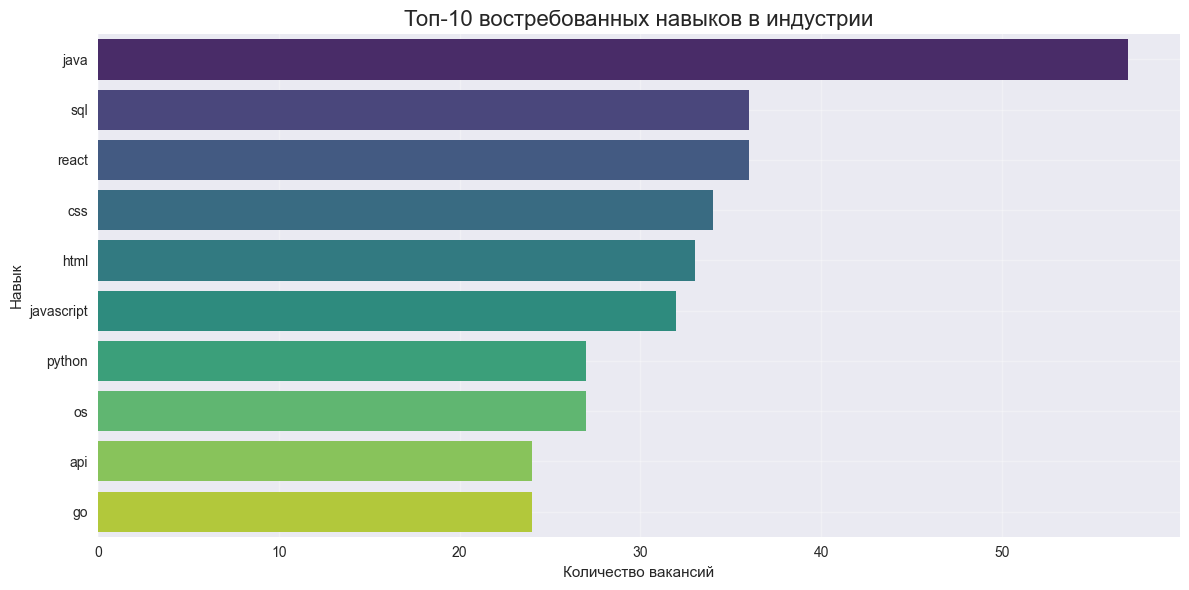

In [6]:
# --- График 1: Топ-10 навыков ---
plt.figure(figsize=(12, 6))
top_skills = df_skills.head(10)
sns.barplot(data=top_skills, x='Частота', y='Навык', palette='viridis')
plt.title('Топ-10 востребованных навыков в индустрии', fontsize=16)
plt.xlabel('Количество вакансий')
plt.ylabel('Навык')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

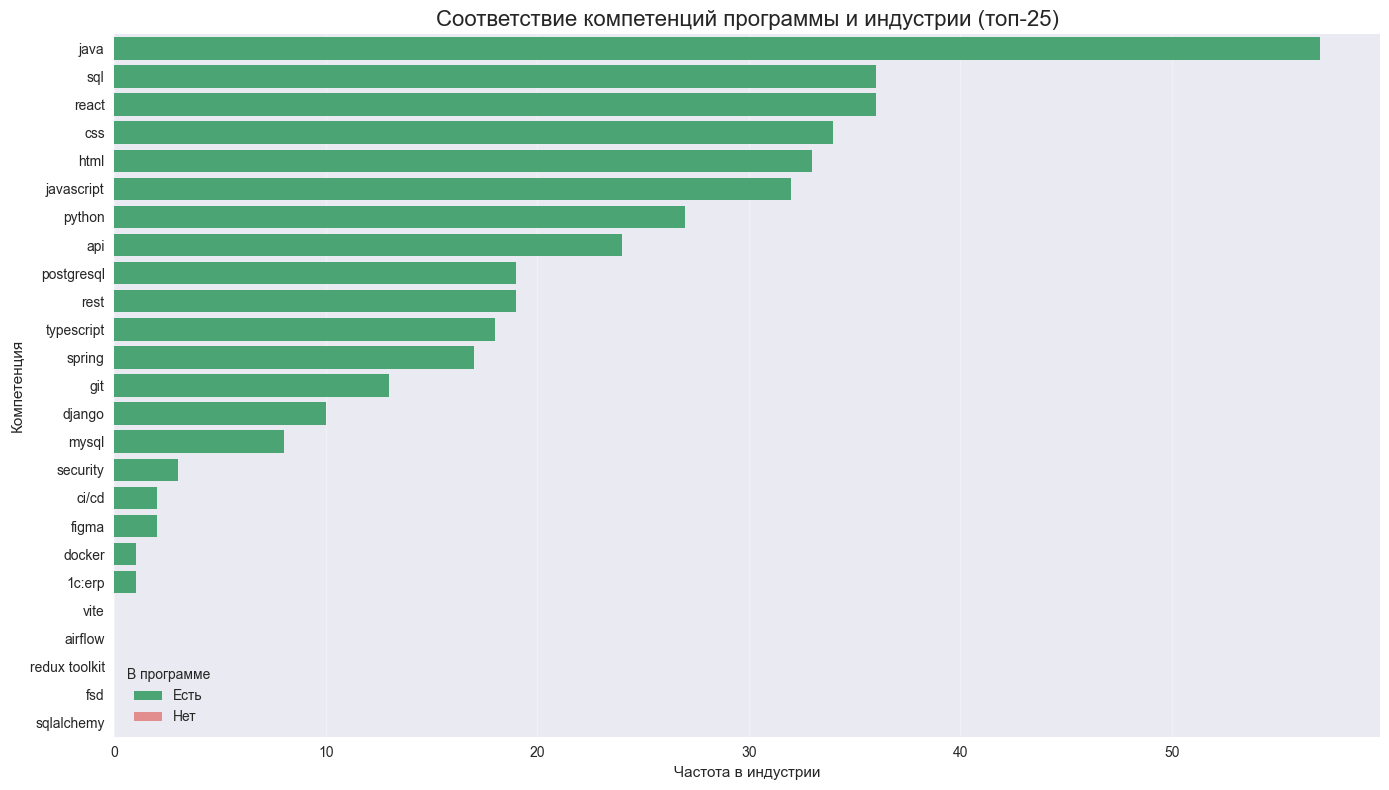

In [7]:
# --- График 2: Соответствие компетенций ---
df_plot = df_matrix.head(25).copy()
df_plot['Цвет'] = df_plot['Есть в индустрии'].map({True: 'Есть', False: 'Нет'})

plt.figure(figsize=(14, 8))
sns.barplot(data=df_plot, x='Частота в индустрии', y='Компетенция', hue='Цвет',
            dodge=False, palette={'Есть': 'mediumseagreen', 'Нет': 'lightcoral'})
plt.title('Соответствие компетенций программы и индустрии (топ-25)', fontsize=16)
plt.xlabel('Частота в индустрии')
plt.ylabel('Компетенция')
plt.grid(True, axis='x', alpha=0.3)
plt.legend(title='В программе')  
plt.tight_layout()
plt.show()

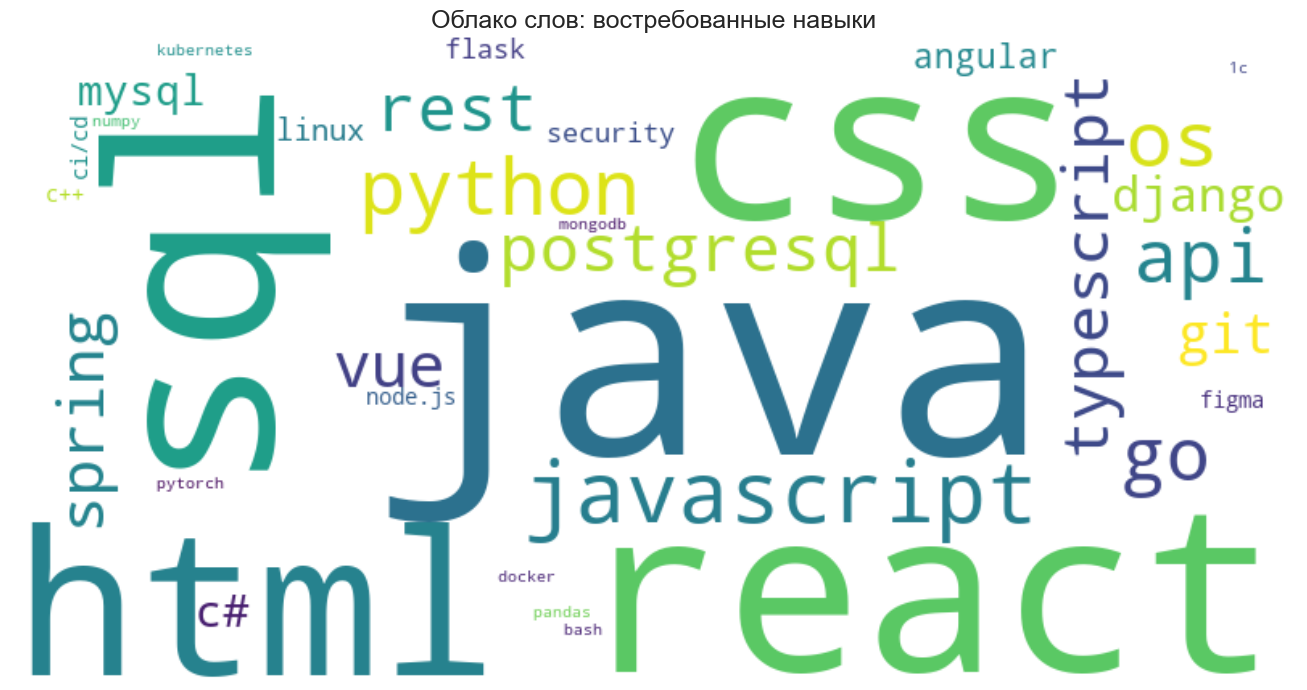

In [8]:
# --- Облако слов ---
if skill_counter:
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis') \
                  .generate_from_frequencies(skill_counter)
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако слов: востребованные навыки', fontsize=18)
    plt.tight_layout()
    plt.show()

In [9]:
# --- Аналитический отчёт ---
print("="*80)
print("📊 АНАЛИТИЧЕСКИЙ ОТЧЕТ ПО ФАЗЕ 1")
print("="*80)

print(f"\n🔹 Общее количество собранных вакансий: {len(vacancies)}")
print(f"🔹 Количество уникальных навыков, найденных в индустрии: {len(skill_counter)}")
print(f"🔹 Топ-3 навыка: {', '.join([x[0] for x in skill_counter.most_common(3)])}")

print(f"\n🔹 Компетенции программы УрФУ: {len(urfu_competencies)}")
print(f"🔹 Навыки, которых нет в программе, но востребованы: {len(industry_only)}")
print(f"🔹 Навыки, которые есть в программе, но редки в индустрии: {len(program_only)}")

print("\n💡 РЕКОМЕНДАЦИИ:")
if len(industry_only) > 0:
    top_missing = sorted(industry_only)[:5]
    print(f"   • Добавить в программу: {', '.join(top_missing)}")
if len(program_only) > 0:
    top_excess = sorted(program_only)[:5]
    print(f"   • Пересмотреть актуальность (для общего ядра): {', '.join(top_excess)}")
    print("     → Эти компетенции лучше вынести в специализированные треки (геймдев, ERP, и т.д.)")

print(f"\n✅ Фаза 1 завершена. Артефакт 'Стратегический Профиль Партнера' готов.")

📊 АНАЛИТИЧЕСКИЙ ОТЧЕТ ПО ФАЗЕ 1

🔹 Общее количество собранных вакансий: 200
🔹 Количество уникальных навыков, найденных в индустрии: 35
🔹 Топ-3 навыка: java, sql, react

🔹 Компетенции программы УрФУ: 59
🔹 Навыки, которых нет в программе, но востребованы: 15
🔹 Навыки, которые есть в программе, но редки в индустрии: 39

💡 РЕКОМЕНДАЦИИ:
   • Добавить в программу: angular, bash, c#, c++, flask
   • Пересмотреть актуальность (для общего ядра): 2d art, agile, airflow, allocation, android
     → Эти компетенции лучше вынести в специализированные треки (геймдев, ERP, и т.д.)

✅ Фаза 1 завершена. Артефакт 'Стратегический Профиль Партнера' готов.


## ФАЗА 2: ФОРМИРОВАНИЕ ПУЛА И СКОРИНГ

In [10]:
# Получаем уникальные ID работодателей
employer_ids = df_vacancies['employer'].apply(
    lambda x: x.get('id') if isinstance(x, dict) and x.get('id') else None
).dropna().unique()

print(f"🔍 Будет загружено до {min(100, len(employer_ids))} профилей компаний...")

🔍 Будет загружено до 100 профилей компаний...


In [11]:
def get_employer_details(emp_id):
    try:
        resp = requests.get(f"https://api.hh.ru/employers/{emp_id}", timeout=5)
        if resp.status_code == 200:
            return resp.json()
    except Exception as e:
        pass
    return None

employer_profiles = []
for eid in list(employer_ids)[:100]:
    profile = get_employer_details(eid)
    if profile:
        employer_profiles.append(profile)
    time.sleep(0.3)

df_companies = pd.DataFrame(employer_profiles)
print(f"✅ Загружено {len(df_companies)} профилей компаний.")

✅ Загружено 100 профилей компаний.


In [12]:
def calculate_score(row, urfu_set):
    score = 0
    descr = str(row.get('description', ''))
    
    # Технологии
    skills = extract_skills_from_description(descr)
    matched = len({normalize(s) for s in skills} & urfu_set)
    score += min(40, matched * 3)
    
    # Масштаб (по числу открытых вакансий как proxy)
    open_vac = row.get('open_vacancies', 0)
    if open_vac > 20: score += 25
    elif open_vac > 10: score += 20
    elif open_vac > 0: score += 15
    else: score += 10
    
    # Регион: Свердловская область?
    area_info = row.get('area')
    if area_info and isinstance(area_info, dict):
        area_name = area_info.get('name', '').lower()
        if 'екатеринбург' in area_name or 'свердлов' in area_name:
            score += 5
    
    # Опыт в образовании
    edu_keywords = ['стажировка', 'вуз', 'студент', 'образование', 'наставничество']
    if any(kw in descr.lower() for kw in edu_keywords):
        score += 15
        
    return min(100, int(score))

df_companies['score'] = df_companies.apply(lambda row: calculate_score(row, norm_urfu), axis=1)
df_companies = df_companies.sort_values('score', ascending=False).reset_index(drop=True)

In [14]:
# Подготовка читаемых полей
df_companies['area_name'] = df_companies['area'].apply(
    lambda x: x.get('name') if isinstance(x, dict) else str(x) if x else "—"
)

df_companies['vacancies_url'] = df_companies['id'].apply(
    lambda emp_id: f"https://hh.ru/vacancies/{emp_id}" if emp_id else "—"
)

# Экспорт Top-20 для верификации
top_20 = df_companies.head(20)[[
    'name', 'score', 'site_url', 'description', 'area_name', 'vacancies_url'
]].copy()

# Добавляем колонки для человека
top_20['include_in_shortlist'] = True
top_20['comments'] = ""

# Создаём папку, если не существует
import os
os.makedirs("templates", exist_ok=True)

# Сохраняем
top_20.to_excel("templates/top_20_companies_for_review.xlsx", index=False)
print("✅ Файл для верификации сохранён: templates/top_20_companies_for_review.xlsx")
print("📄 Откройте Excel, отметьте нужные компании (include_in_shortlist = True) и сохраните как top_10_verified.xlsx")

✅ Файл для верификации сохранён: templates/top_20_companies_for_review.xlsx
📄 Откройте Excel, отметьте нужные компании (include_in_shortlist = True) и сохраните как top_10_verified.xlsx


C:\Users\alivka\AppData\Local\Temp\ipykernel_6208\3767976095.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_companies.head(10), x='score', y='name', palette='coolwarm')
C:\Users\alivka\AppData\Local\Temp\ipykernel_6208\3767976095.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


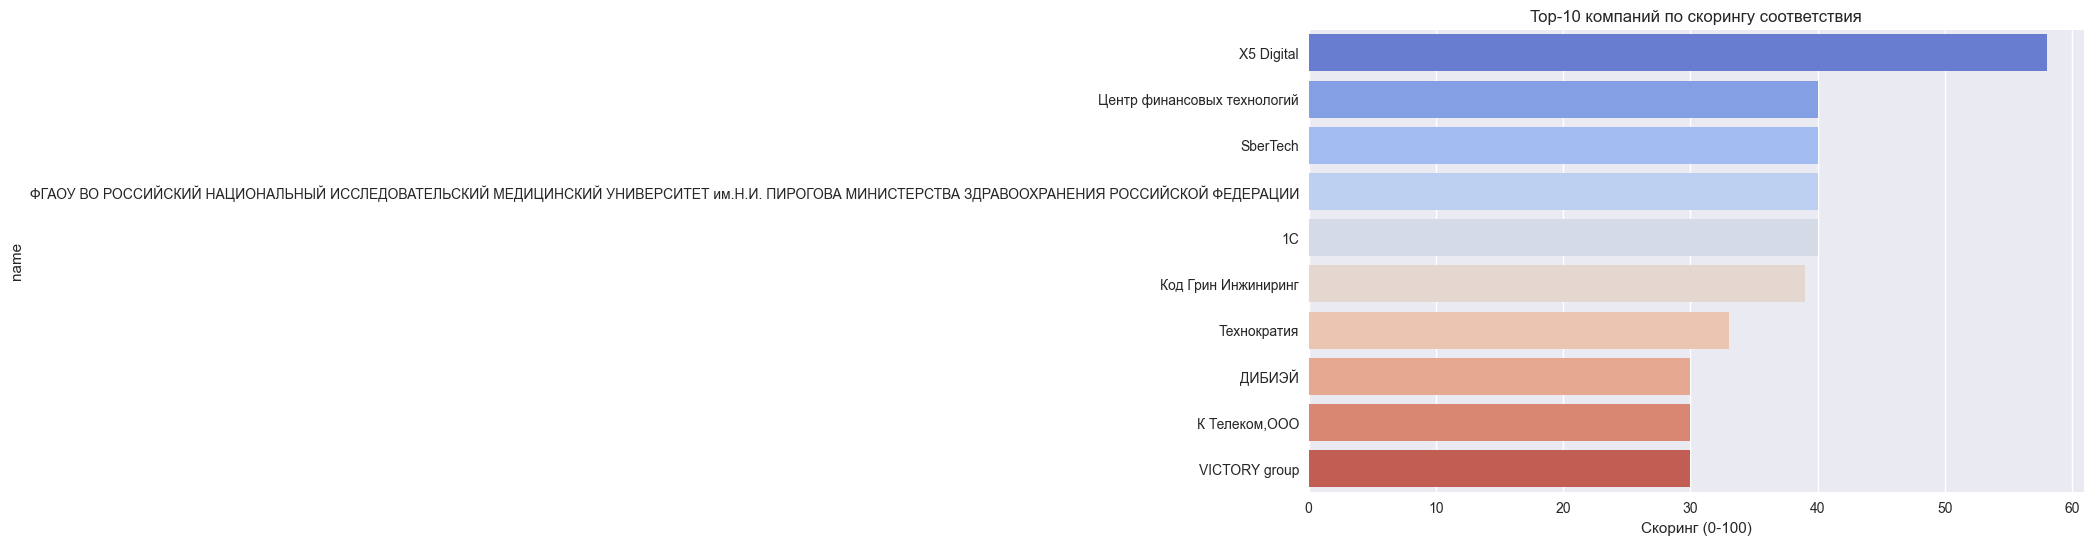

In [15]:
# Опционально: визуализация Top-10
plt.figure(figsize=(10, 6))
sns.barplot(data=df_companies.head(10), x='score', y='name', palette='coolwarm')
plt.title('Top-10 компаний по скорингу соответствия')
plt.xlabel('Скоринг (0-100)')
plt.tight_layout()
plt.show()